## Simple Shape circuit Extraction Demo notebook

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
#hardware
device = 'cuda:0'

from circuit_pruner.utils import load_config

config = load_config('./configs/alexnet_sparse_config.py')
model = config.model.to(device)



#general
import torch
import os
from copy import deepcopy
from circuit_pruner.force import setup_net_for_circuit_prune, show_model_layer_names

#### feature target 

In [4]:
#circle feature
layer = 'features_8'
unit = 53

feature_targets = {layer:[unit]}

### general circuit

In [5]:
general_ranks = torch.load('quick_start/features_8_53_alexnetsparse_actgrad_ranks.pt')

alexnet_sparse_features_8:53_1640635535.2542477.pt
found


In [6]:
import pickle
df = pickle.load(open('quick_start/dist_df.pkl','rb'))

In [7]:
df.loc[(df['model']=='alexnet_sparse') & (df['layer']==layer) & (df['method']=='actxgrad') & (df['unit']==unit)][['sparsity','effective_sparsity','pruned_pearson']]

,sparsity,effective_sparsity,pruned_pearson
41991,0.001,0.000000,0.000000
41992,0.005,0.000658,0.304487
41993,0.010,0.003049,0.131389
41994,0.050,0.039842,0.495238
41995,0.100,0.096175,0.815591
41996,0.200,0.199372,0.951118
41997,0.300,0.299958,0.992698
41998,0.400,0.399887,0.999631
41999,0.500,0.499677,0.999998
42000,0.600,0.599813,1.000000


In [8]:
from circuit_pruner.extraction import model_ranks_2_circuit_model
from circuit_pruner.utils import circuit_2_model_sparsity

sparsity = .4

general_circuit,general_mask = model_ranks_2_circuit_model(general_ranks,sparsity,model,
                                                                     feature_targets,device,structure='edges',
                                                                     use_effective_mask=True)

general_circuit = general_circuit.eval().to('cpu')

for l in general_mask:
    l = l.to('cpu')
    
    
circuit_feature_targets = {layer:[0]}

general_circuit_sparsity_factor = circuit_2_model_sparsity(general_circuit,model)

features_8 effective last layer
target sparsity: 0.4
total params to feature: 86592

kept params in original mask: 34637      (total params * sparsity)
original mask: 483772 params
effective mask: 483682 params
effective_sparsity: 0.39987527716186255
filter sparsity: 0.7236234294161124
kernel sparsity: 0.5526013405681456


In [9]:
general_circuit_sparsity_factor

0.39987527716186255

#### feature visualization of general circuit

  1%|          | 3/512 [00:00<00:17, 29.86it/s]

------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 
        8               [13, 13]       15.5       16.0            99.0 
        9               [13, 13]       15.5       16.0           131.0 


100%|██████████| 512/512 [00:15<00:00, 32.35it/s]



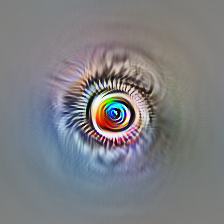

(13, 13)
(6, 6)
[(46.0, 177.0), (46.0, 177.0)]


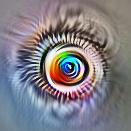

In [11]:
from circuit_pruner.visualizer.featureviz  import featviz_in_recep_field

featviz_in_recep_field(deepcopy(general_circuit),layer,0,margin=0)

### dataloaders

#### preprocess

In [12]:
from torchvision import transforms
from circuit_pruner.receptive_fields import receptive_field_fit_transform

target_position = [5,5]   #which location of the target filter's activation map do we want to fit these images to
rff_transform = receptive_field_fit_transform(layer,target_position,model=general_circuit)
#try adding the argument "shrinkage = .5" above

preprocess = config.preprocess
preprocess =  transforms.Compose([preprocess,
                                  rff_transform])

------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [244, 244]        0.5        1.0             1.0 
        1               [60, 60]        3.5        4.0            11.0 
        2               [60, 60]        3.5        4.0            11.0 
        3               [29, 29]        7.5        8.0            19.0 
        4               [29, 29]        7.5        8.0            51.0 
        5               [29, 29]        7.5        8.0            51.0 
        6               [14, 14]       15.5       16.0            67.0 
        7               [14, 14]       15.5       16.0            99.0 
        8               [14, 14]       15.5       16.0            99.0 
        9               [14, 14]       15.5       16.0           131.0 
[(30.0, 161.0), (30.0, 161.0)]


In [ ]:
from PIL import Image, ImageOps
from torchvision import transforms
import os

topil = transforms.ToPILImage()

images = ['empty_circle.jpg','small_circle.jpg']

img_root_path = './image_data/sample_data/circles/'
for image in images:
    img = Image.open(os.path.join(img_root_path,image))
    img_t = preprocess(img)
    img = topil(img_t)
    display(img)

#### dataloader classes

In [15]:
from circuit_pruner.data_loading import rank_image_data
from circuit_pruner.data_loading import single_image_data
from torchvision import transforms
from torch.utils import data



kwargs = {'num_workers': 1, 'pin_memory': True, 'sampler':None} if 'cuda' in device else {}

dataloaders = {}

for image in images:
    dataloaders[image] = data.DataLoader(single_image_data(img_root_path +image,preprocess),
                                         batch_size=1,
                                         shuffle=False,
                                         **kwargs)
    



#### generate ranks

In [16]:
from circuit_pruner.dissected_Conv2d import set_across_model, set_model_target_node
from circuit_pruner.dissected_Conv2d import get_ranklist_from_dissected_Conv2d_modules, clear_ranks_across_model
from copy import deepcopy
from circuit_pruner.dissected_Conv2d import dissect_model

structure = 'kernels'

ranks = {}


for image in images:
    print(image)
    
    rankable_model = dissect_model(deepcopy(general_circuit), dissect=True,store_ranks = True, device=device)
    rankable_model.to(device)

    set_model_target_node(rankable_model,layer,0)

    set_across_model(rankable_model,'rank_field',target_position)#we want to get ranks with respect to our filters response at the target position 

    set_across_model(rankable_model,'absolute_rank',True)
    
    iter_dataloader = iter(dataloaders[image])
    iters = len(iter_dataloader)

    #actually extract ranks by running images through model
    clear_ranks_across_model(rankable_model)

    for it in range(iters):

        inputs, label = next(iter_dataloader)
        inputs = inputs.to(device)

        rankable_model.zero_grad()

        try:
            outputs = rankable_model(inputs)
        except:
            pass


    ranks[image] = get_ranklist_from_dissected_Conv2d_modules(rankable_model)
    
    del rankable_model
    torch.cuda.empty_cache()

empty_circle.jpg
small_circle.jpg


#### activation preservation as function of sparsity

In [ ]:
from circuit_pruner.extraction import get_preservation_at_sparsities
import numpy as np

ranker = ranks

structure='kernels'


sparsities = np.linspace(.9999, .01, num=10)
#in paper num is set to '70' here, but that takes times

model_sparsities = []
for sparsity in sparsities:
    model_sparsities.append(sparsity*general_circuit_sparsity_factor) 


scores = {}
for image in images:
    scores[image.replace('.jpg','_circuit')] = {}

for rank_image in images:
    for data_image in images:
        print('\n\n\n')
        print(rank_image)
        print(data_image)
        print('\n\n\n')
        scores[rank_image.replace('.jpg','_circuit')][data_image.replace('.jpg','_data')] = get_preservation_at_sparsities(
            
                                                                general_circuit,
                                                                ranker[rank_image],
                                                                circuit_feature_targets,
                                                                dataloaders[data_image],
                                                                sparsities,device,metric='all',
                                                                rank_field = target_position,
                                                                structure=structure)


In [148]:
means = {}

for image in images:
    image_root = image.replace('.jpg','')
    means[image_root+'_data'] = scores[image_root+'_circuit'][image_root+'_data'][layer+':0']['avg_diff'][6]/scores[image_root+'_circuit'][image_root+'_data'][layer+':0']['mean_normed_diff'][6]

In [149]:
import plotly.graph_objects as go
import plotly.express as px


x_axis = model_sparsities

metric = 'avg_abs_diff'
mean_norm = True


color_dict = {
               'empty_circle_circuit':px.colors.qualitative.T10[0],
               'small_circle_circuit':px.colors.qualitative.T10[1],
             }




fig = go.Figure()

for circuit in scores:
    for data in scores[circuit]:
        # Create and style traces
        if data.replace('_data','') == circuit.replace('_circuit',''):
            linetype = None
        else:
            linetype = 'dot'
            
        name = (circuit+' : '+data).replace('_',' ').replace('empty','big').replace('data','image')
        y = np.array(scores[circuit][data]['%s:%s'%(layer,0)][metric])
        if mean_norm:
            y = y/means[data]
        x = x_axis[0:len(scores[circuit][data]['%s:%s'%(layer,0)][metric])]
        fig.add_trace(go.Scatter(x=x, y=y, name=name,
                         line=dict(color=color_dict[circuit], width=4,dash=linetype)))

# Edit the layout
fig.update_layout( width = 720,
                   plot_bgcolor = 'rgba(255,255,255,1)',
                   paper_bgcolor = 'rgba(255,255,255,1)',
                   xaxis_title='sparsity',
                   yaxis_title=r'${\Delta\mathcal{F}_{norm}}$',
                  legend=dict(
                                yanchor="top",
                                y=0.95,
                                xanchor="left",
                                x=0.03,
                                bgcolor='rgba(255,255,255,0.3)'
                              )
                 )
fig.update_xaxes(autorange="reversed",gridcolor='rgb(210,210,210)',gridwidth=1)
fig.update_yaxes(gridcolor='rgb(210,210,210)',gridwidth=1)

fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [.5, .4, .3, .2, .1]
    )
)



fig.show()

#### Extract circuits at preserving sparsity

In [142]:
# extraction at last good sparsity

from circuit_pruner.extraction import model_ranks_2_circuit_model

ranker = ranks

#sparsities are with respect to the general circuit, not the original model
# target_sparsities = {'empty_circle.jpg':0.06738551,
#                     'small_circle.jpg':0.09607826} 
target_sparsities = {'empty_circle.jpg':0.068,
                     'small_circle.jpg':0.096} 


sparse_circuits = {}
sparse_masks = {}

for image in images:
    sparse_circuit,sparse_mask = model_ranks_2_circuit_model(ranker[image],target_sparsities[image],
                                                           general_circuit,circuit_feature_targets,device,
                                                           structure='kernels',use_effective_mask=True,
                                                           rank_field=target_position)
    sparse_circuits[image] = sparse_circuit.to(device)
    sparse_masks[image] = sparse_mask


features_8 effective last layer
target sparsity: 0.068
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34626    (after subtracting previously masked params)
kept params in original mask: 2355      (total params * sparsity)
original mask: 34491 params
effective mask: 22583 params
effective_sparsity: 0.04433084965055161
features_8 effective last layer
target sparsity: 0.096
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34626    (after subtracting previously masked params)
kept params in original mask: 3325      (total params * sparsity)
original mask: 48789 params
effective mask: 33416 params
effective_sparsity: 0.06030150753768844


In [141]:
sparse_circuits

{'empty_circle.jpg': Sequential(
   (features_0): Conv2d(3, 27, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
   (features_1): ReLU(inplace=True)
   (features_2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
   (features_3): Conv2d(27, 82, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
   (features_4): ReLU(inplace=True)
   (features_5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
   (features_6): Conv2d(82, 103, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (features_7): ReLU(inplace=True)
   (features_8): Conv2d(103, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 ),
 'small_circle.jpg': Sequential(
   (features_0): Conv2d(3, 39, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
   (features_1): ReLU(inplace=True)
   (features_2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
   (features_3): Conv2d(39, 90, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
   (featu

In [138]:
from circuit_pruner.visualizer.featureviz  import featviz_in_recep_field

  1%|          | 5/512 [00:00<00:10, 49.74it/s]

------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 
        8               [13, 13]       15.5       16.0            99.0 
        9               [13, 13]       15.5       16.0           131.0 


100%|██████████| 512/512 [00:09<00:00, 51.51it/s]



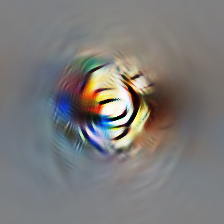

(13, 13)
(6, 6)
[(46.0, 177.0), (46.0, 177.0)]


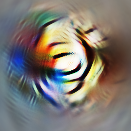

In [139]:
featviz_in_recep_field(deepcopy(sparse_circuits['empty_circle.jpg']),layer,0,margin=0)

  1%|          | 5/512 [00:00<00:10, 46.79it/s]

------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 
        8               [13, 13]       15.5       16.0            99.0 
        9               [13, 13]       15.5       16.0           131.0 


100%|██████████| 512/512 [00:10<00:00, 46.68it/s]



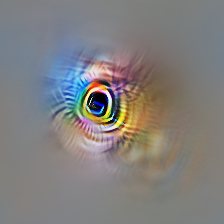

(13, 13)
(6, 6)
[(46.0, 177.0), (46.0, 177.0)]


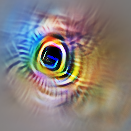

In [143]:
featviz_in_recep_field(deepcopy(sparse_circuits['small_circle.jpg']),layer,0,margin=0)

#### Compare IoU of extracted circuits

In [144]:
from circuit_pruner.utils import plot_iou_from_masks

In [145]:
iou_fig = plot_iou_from_masks(sparse_masks['empty_circle.jpg'],sparse_masks['small_circle.jpg'])


In [146]:
iou_fig